In [1]:

import intake
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# Install pyclimdex

# !pip install pyclimdex

In [3]:
import climdex.precipitation as pdex # install pyclimdex in previous cell if not installed
import climdex.temperature as tdex 

In [4]:
catalog = intake.open_esm_datastore(
    'https://raw.githubusercontent.com/NCAR/cesm2-le-aws/main/intake-catalogs/aws-cesm2-le.json'
)

catalog = catalog.search(variable=['TREFHTMN', 'TREFHTMX'], frequency='daily')
dsets = catalog.to_dataset_dict(storage_options={"anon":True})
dsets.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


dict_keys(['atm.ssp370.daily.cmip6', 'atm.ssp370.daily.smbb', 'atm.historical.daily.cmip6', 'atm.historical.daily.smbb'])

In [5]:
hist_cmip6 = dsets['atm.historical.daily.cmip6']
hist_cmip6

<xarray.Dataset> Size: 1TB
Dimensions:    (member_id: 50, time: 60225, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, nbnd) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHTMN   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
    TREFHTMX   (member_id, time, lat, lon) float32 666GB dask.array<chunksize=(1, 730, 192, 288), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                       CF-1.0
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  day_1
    topography_file:                   /mnt/lustre/share/CESM/cesm_input/atm/...
    ...                                ...
    intake_esm_attrs:spatial_domain:   global
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       1850-01-01 12:00:00
    intake_esm_attrs:end_time:         2014-12-31 12:00:00
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.historical.daily.cmip6

In [6]:
hist_cmip6['TREFHTMX']

<xarray.DataArray 'TREFHTMX' (member_id: 50, time: 60225, lat: 192, lon: 288)> Size: 666GB
dask.array<open_dataset-TREFHTMX, shape=(50, 60225, 192, 288), dtype=float32, chunksize=(1, 730, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Attributes:
    cell_methods:  time: maximum
    long_name:     Maximum reference height temperature over output period
    units:         K

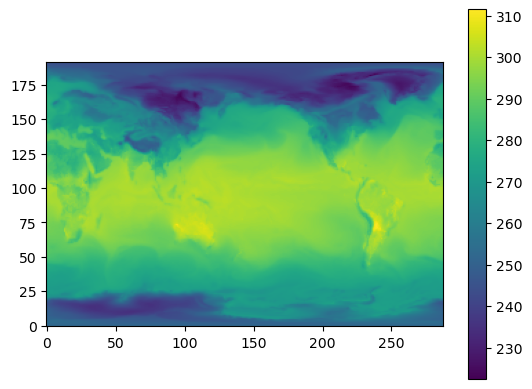

In [8]:
# plots max tref for first member of first time step
plt.imshow(hist_cmip6['TREFHTMX'].data[0,0], origin='lower')
plt.colorbar()

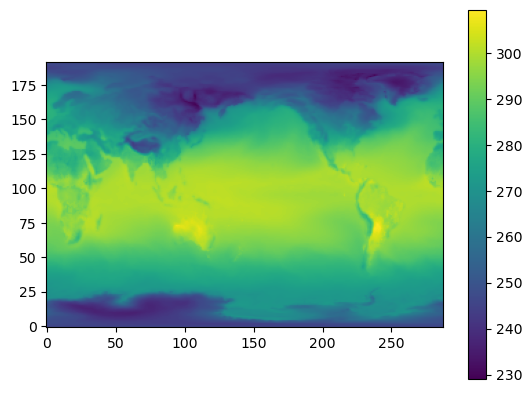

In [10]:
# plots mean trefhtmx across all 50 members for first time step
plt.imshow(hist_cmip6['TREFHTMX'].data[:,0].mean(axis=0), origin='lower')
plt.colorbar()

In [ ]:
tindices = tdex.indices(time_dim='time', convert_units_fn= lambda x: x-273.15) # the parameter convert_units_fn should hopefully convert temperature from Kelvin to Celsius
m_txx = tindices.monthly_txx(hist_cmip6['TREFHTMX'].data[0].compute()) # calculate monthly txx from first member of data

In [16]:
hist_cmip6['TREFHTMX'].data[0]

dask.array<getitem, shape=(60225, 192, 288), dtype=float32, chunksize=(730, 192, 288), chunktype=numpy.ndarray>